# CSCI1470 Final Project: CNN-Bi-LSTM for SARS CoV-2 Classification
### Aidan Harbison, Corinn Tiffany, Rachel Chae, Zyn Yee Ang
[Link to original Google Colab file](https://colab.research.google.com/drive/1udGhYULmhbM2VSLjWx0ZRjXBkBAcib3j?usp=sharing)
[Link to the paper that was used as inspiration for this project](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8545213/)

In [ ]:
!pip install biopython # http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc109

from Bio import SeqIO, Entrez # https://biopython.org/docs/1.76/api/Bio.Entrez.html#
Entrez.email = "aidan_harbison@brown.edu" # email for NCBI to contact in case of excessive access requests, EDIT as needed

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

FILEPATH = "drive/Shareddrives/CSCI1470 Final Project/" # EDIT as needed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.4 MB/s eta 0:00:00
Mounted at /content/drive


# NCBI DATASET CODE + FILE PROCESSING
The first following code block uses Entrez in Biopython to create a text file of NCBI gene IDs in `FILEPATH/genes/gene_ids.txt` that are associated with Coronaviridae (taxonomy ID of 11118). This text file can be used to download the associated gene sequences as FASTA files using [NCBI Datasets](https://ncbi.nlm.nih.gov/datasets/tables/genes/). Items marked as "NEWENTRY" will not be able to be downloaded.

After you have manually extracted the `.fna` files from the downloads and placed them in the `FILEPATH/genes` directory, the second code block appends all downloaded `.fna` files into one `gene.fna` file in the same directory. After creating this file, this section does not need to be rerun.



In [ ]:
gene_handle = Entrez.esearch(db="gene", term="txid11118[Organism] AND alive[prop]", retmax=1000) # 616
gene_record = Entrez.read(gene_handle)
gi_list = gene_record["IdList"] # list of NCBI genes ids
gi_str = ", ".join(gi_list)
with open(FILEPATH + "genes/gene_ids.txt", "w") as f:
    f.write(gi_str)

In [ ]:
# combines downloads .fna files that are in genes directory in FILEPATH
import glob

directory = FILEPATH + "genes/"
files = glob.glob(directory + "*.fna")
with open(directory + "gene.fna", "w") as outfile:
    for file in files:
        with open(file, "r") as infile:
            outfile.write(infile.read())

# DATA PROCESSING

The following code block extracts the gene sequence information from the composite `gene.fna` file using Biopython's SeqIO, removing duplicate gene sequences and gene sequences that have base pairs that are not A, T, G, or C. Gene sequence, gene description, and organism are stored in a dictionary which is appended to the list `gene_dicts`.

In [ ]:
import re

gene_dicts = []
bps = set("ATGC")
seen = set()
for record in SeqIO.parse(FILEPATH + "genes/gene.fna", "fasta"):
  organism = re.search(r"\[organism=(.*?)\]", record.description).group(1)
  organism = "SARS COV-2" \
    if organism == "Severe acute respiratory syndrome coronavirus 2" or organism == "SARS coronavirus Tor2" \
    else organism
  gene_seq = str(record.seq)

  if gene_seq not in seen and set(gene_seq).issubset(bps): # remove sequences with unknown characters
      seen.add(gene_seq)
      gene_dicts.append({"desc": record.description, "org" : organism, "seq" : gene_seq})

print(f"{len(gene_dicts)} unique genes")
num_sars = sum([1 for gene_dict in gene_dicts if gene_dict["org"] == "SARS COV-2"])
print(f"{num_sars} number of SARS-COV2 gene sequences in gene_dicts, whereas paper has 34")
print(f"{num_sars / len(gene_dicts) * 100}% of genes are SARS-COV2 genes, whereas paper has {34/329*100}%")

531 unique genes
24 number of SARS-COV2 gene sequences in gene_dicts, whereas paper has 34
4.519774011299435% of genes are SARS-COV2 genes, whereas paper has 10.33434650455927%


The following code block splits up gene sequences into random 500 bp sequences, which are stored with the same information of gene description, organism, and sequence in `seqs`.

In [ ]:
from random import randint

max_seq_len = 500
seqs = []
for gene_dict in gene_dicts:
  gene_len = len(gene_dict["seq"])
  if gene_len < max_seq_len:
    seqs.append(gene_dict)
  else:
    num_samples = gene_len // max_seq_len
    for _ in range(num_samples):
      start = randint(0, gene_len - max_seq_len)
      end = start + max_seq_len
      seq = gene_dict["seq"][start:end]
      seqs.append({"desc" : gene_dict["desc"], "org" : gene_dict["org"], "seq" : seq})

print(f"{len(seqs)} unique sequences")
num_sars = sum([1 for seq_dict in seqs if seq_dict["org"] == "SARS COV-2"])
print(f"{num_sars} number of SARS-COV2 sequences in seqs, whereas paper has 34")
print(f"{num_sars / len(seqs) * 100}% of sequences are SARS-COV2 sequences, whereas paper has {34/329*100}%")

3493 unique sequences
120 number of SARS-COV2 sequences in seqs, whereas paper has 34
3.4354423131978242% of sequences are SARS-COV2 sequences, whereas paper has 10.33434650455927%


The following code block splits up each sequence into trigrams and converts each trigram to a one hot encoding (following [this paper](https://www.scirp.org/journal/paperinformation.aspx?paperid=65923)). The code for `generate_trigrams` was based on an [ngram tutorial found online](https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/). The sequence of one hot encodings for each sequence is stored in `data`, and the sequences are labeled as SARS-CoV-2 (1) or normal coronavirus (0) in `labels`.

In [ ]:
import numpy as np

def generate_trigrams(gene : str) -> list[str]:
  bps = [*gene]
  temp = zip(*[bps[i:] for i in range(0, 3)])
  ans = [''.join(ngram) for ngram in temp]
  return ans

bp_dict = {'A':0,'C':1,'G':2,'T':3}
def convert_gene(gene : str, to_fill : np.array):
  trigrams = generate_trigrams(gene)
  def trigram_to_index(tr : str):
    return ((4**2) * bp_dict[tr[0]]) + (4 * bp_dict[tr[1]]) + bp_dict[tr[2]]
  bp_indices = [trigram_to_index(trigram) for trigram in trigrams]

  for i, bp_i in enumerate(bp_indices):
    to_fill[i, bp_i] = 1

num_seq = len(seqs)
data = np.zeros(shape=(num_seq, max_seq_len-2, 64))
labels = np.zeros(shape=(num_seq))
for i, seq_d in enumerate(seqs):
  convert_gene(str(seq_d['seq']), data[i])
  if seq_d['org'] == "SARS COV-2":
    labels[i] = 1

This code creates class weights (`class_weight`) following a [TensorFlow tutorial for imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) which is used in `model.fit` below. This allows us to compute a weighted binary cross-entropy loss.

In [ ]:
pos = sum([1 for seq_d in seqs if seq_d["org"] == "SARS COV-2"])
neg = len(seqs) - pos
weight_for_0 = (1 / neg) * (len(seqs) / 2.0)
weight_for_1 = (1 / pos) * (len(seqs) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

The following code block splits `data` and `labels` into training, validation, and testing splits, creates the model, and trains it.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.models import Sequential

class SARSClassifier(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.conv = Sequential([
        Conv1D(filters=8, kernel_size=3),
        Conv1D(filters=8, kernel_size=3),
        Conv1D(filters=8, kernel_size=3),
        Dropout(rate=0.1)
    ], name="conv")
    self.maxpool = Sequential([
        MaxPool1D(pool_size=2, strides=2),
        Dropout(rate=0.1)
    ], name="maxpool")
    self.bilstm = Bidirectional(LSTM(units=32, dropout=0.1), merge_mode="concat", name="bilstm")
    self.output_layer = Dense(units=1, activation="sigmoid", name="output")

  def call(self, x):
    x = self.conv(x)
    x = self.maxpool(x)
    x = self.bilstm(x)
    return self.output_layer(x)

model = SARSClassifier()

model.compile(
    optimizer   = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss        = tf.keras.losses.BinaryCrossentropy(),
    metrics     = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                   tf.keras.metrics.Precision(name='precision'),
                   tf.keras.metrics.Recall(name='recall'),
                   tf.keras.metrics.SensitivityAtSpecificity(specificity=0.5, name='sensitivity'),
                   tf.keras.metrics.SpecificityAtSensitivity(sensitivity=0.5, name='specificity')]
)

model.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 64,
    validation_data = (X_validation, y_validation),
    class_weight = class_weight,
)

Epoch 1/50
35/35 [==============================] - 8s 66ms/step - loss: 0.6896 - accuracy: 0.4814 - precision: 0.0391 - recall: 0.6053 - sensitivity: 0.3421 - specificity: 0.3080 - val_loss: 0.6892 - val_accuracy: 0.6673 - val_precision: 0.0171 - val_recall: 0.1765 - val_sensitivity: 0.1176 - val_specificity: 0.1236
Epoch 2/50
35/35 [==============================] - 1s 38ms/step - loss: 0.6885 - accuracy: 0.7051 - precision: 0.0438 - recall: 0.3684 - sensitivity: 0.5658 - specificity: 0.5484 - val_loss: 0.6843 - val_accuracy: 0.8301 - val_precision: 0.0244 - val_recall: 0.1176 - val_sensitivity: 0.2941 - val_specificity: 0.2823
Epoch 3/50
35/35 [==============================] - 1s 42ms/step - loss: 0.6879 - accuracy: 0.8336 - precision: 0.0515 - recall: 0.2237 - sensitivity: 0.4211 - specificity: 0.4104 - val_loss: 0.6801 - val_accuracy: 0.8909 - val_precision: 0.0417 - val_recall: 0.1176 - val_sensitivity: 0.2353 - val_specificity: 0.4668
Epoch 4/50
35/35 [=========================

In [ ]:
loss, acc, prec, recall, sens, spec = model.evaluate(X_test, y_test)
print(f"TESTING\nLoss: {loss}\nBinary accuracy: {acc}\nPrecision: {prec}\nRecall: {recall}\nSensitivity: {sens}\nSpecificity: {spec}")

TESTING
Loss: 0.3625081479549408
Binary accuracy: 0.8125894069671631
Precision: 0.15789473056793213
Recall: 0.8888888955116272
Sensitivity: 0.9629629850387573
Specificity: 0.9434523582458496


The following code generates a confusion matrix of the model's performance on the testing data.

22/22 [==============================] - 1s 13ms/step


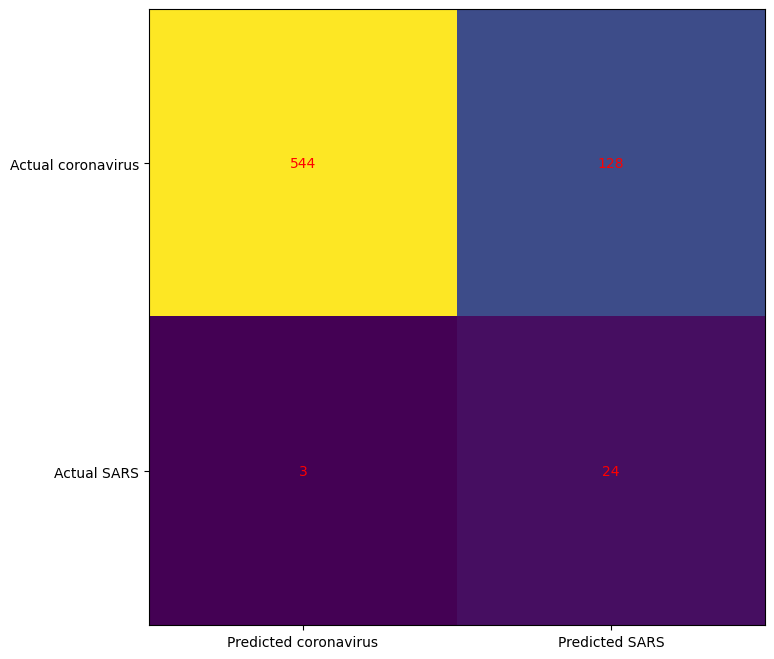

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

preds = model.predict(X_test)
y_pred = np.where(preds > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted coronavirus', 'Predicted SARS'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual coronavirus', 'Actual SARS'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

The following code prints out information of the ten input sequences to the model that generated the highest output (in theory, those with the highest probability to be SARS-CoV-2). For each, its "probability" of being SARS-CoV-2 is printed, then its index in the `seqs` array, then the organism and description of the gene the sequence comes from.

In [ ]:
preds = model.predict(X_test)
preds = [pred[0] for pred in preds]
top10_indices = np.argpartition(preds, -10)[-10:]

for test_i in top10_indices:
  print(preds[test_i])
  for data_i in range(len(data)):
    if (data[data_i] == X_test[test_i]).all():
      print(data_i)
      print(seqs[data_i]['org'])
      print(seqs[data_i]['desc'])
      print()

22/22 [==============================] - 0s 12ms/step
0.87237334
2644
Thrush coronavirus HKU12-600
NC_011549.1:19433-23011 S [organism=Thrush coronavirus HKU12-600] [GeneID=7040215] [chromosome=]

0.87411153
80
SARS COV-2
NC_004718.3:265-21485 ORF1ab [organism=SARS coronavirus Tor2] [GeneID=1489680] [chromosome=]

0.8755307
2868
BtMr-AlphaCoV/SAX2011
NC_028811.1:26041-27330 AVU60_gp6 [organism=BtMr-AlphaCoV/SAX2011] [GeneID=26626801] [chromosome=]

0.88123834
1760
Bat coronavirus
NC_034440.1:28311-29558 N [organism=Bat coronavirus] [GeneID=37627557] [chromosome=]

0.87922937
1022
Bat Hp-betacoronavirus/Zhejiang2013
NC_025217.1:23563-27516 S [organism=Bat Hp-betacoronavirus/Zhejiang2013] [GeneID=20522555] [chromosome=]

0.88385344
3148
White-eye coronavirus HKU16
NC_016991.1:19379-22918 S [organism=White-eye coronavirus HKU16] [GeneID=11945622] [chromosome=]

0.90344673
32
SARS COV-2
NC_045512.2:266-21555 ORF1ab [organism=Severe acute respiratory syndrome coronavirus 2] [GeneID=43740578

The following code generates a plot of the gradients of the output of the model with respect to a specific input sequence in `X_test` (here, the correctly classified SARS-CoV-2 sequence with an index of 32, which was taken from the above code).

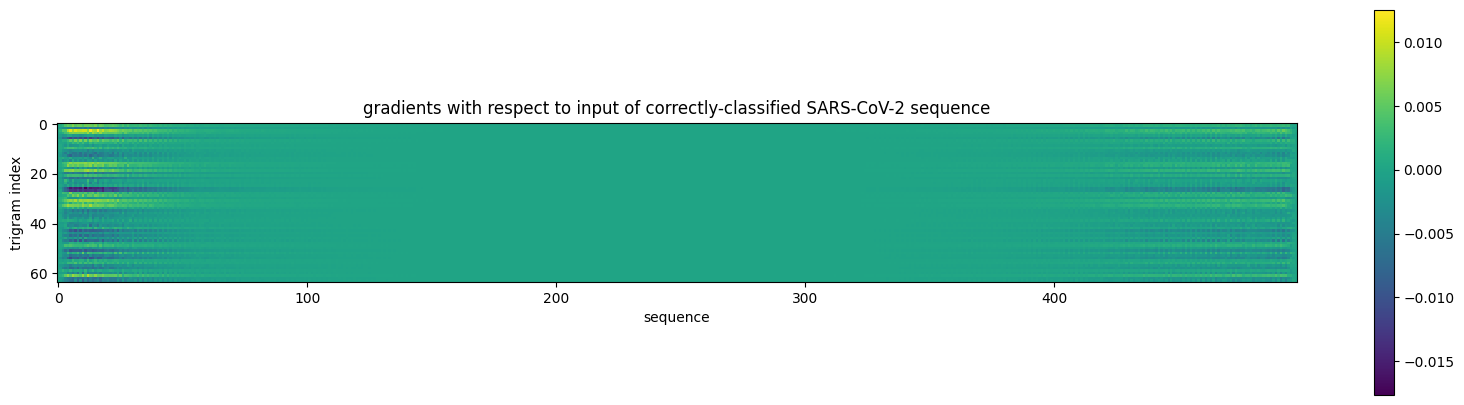

In [ ]:
import matplotlib.pyplot as plt

input = tf.Variable(X_test[32])
with tf.GradientTape() as tape:
  tape.watch(input)
  output = model(tf.expand_dims(input, axis=0))

grads = tf.transpose(tape.gradient(output, input))

plt.figure(figsize=(20, 5))
plt.imshow(grads, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('gradients with respect to input of correctly-classified SARS-CoV-2 sequence')
plt.xlabel('sequence')
plt.ylabel('trigram index')

# show the plot
plt.show()